In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools

# Zorg dat alle kolommen naast elkaar worden getoond
pd.set_option('display.max_columns', None)  # Geen limiet op aantal kolommen
pd.set_option('display.width', 1000)        # Maak de 'virtuele' pagina heel breed
pd.set_option('display.max_colwidth', 50)   # Kort hele lange cel-inhoud (zoals die lijsten) iets in voor de leesbaarheid

In [9]:
import numpy as np
import pandas as pd
import itertools

# ----------------------------
# 1. PARAMETERS
# ----------------------------
Hsmax = 0.11
g = 9.81
Dn50 = 0.04
Ns = 2.8
Desnity = (2367-1000)/1000   #Density met tabel Xbloc
Hs = Ns * (Desnity*Dn50)
gamma_v = 1.0
cot_alpha = 1.33
toe_level = 0.243
TANK_WIDTH = 0.6       # Breedte van de bak

# --- CREST HEIGHTS ---
crest_height_hb1 = 0.56
#crest_height_hb2 = 0.52

# Berm configuraties
berm_heights = np.array([0.4]) 

# --- LIJSTEN ---
h_b_list1 = [0, 0.05]        # Hoort bij Berm 1
#h_b_list2 = [-0.05, 0]       # Hoort bij Berm 2

Hm0_array1 = np.append(np.linspace(0.6 * Hsmax, 1 * Hsmax, 4), np.linspace(1.1*Hsmax, 1.4*Hsmax, 3) )# Hoort bij Berm 1
Hm0_array2 = np.append(np.linspace(0.6 * Hsmax, 1 * Hsmax, 5), np.linspace(1.1*Hsmax, 1.4*Hsmax, 3)) # Hoort bij Berm 2

berm_widths = [4*Dn50, 8*Dn50]
steepness_array = [0.02, 0.04]
TIME_DURATION = 1200 # Seconden

toe_w=0.083         # Teen breedte
toe_h=0.055         # Teen hoogte
toe_sh=3            # Teen helling horizontaal
toe_sv=4

# --- MAPPINGS (AANGEPAST: Lijsten i.p.v. Dictionaries ivm dubbele keys) ---

# OUDE CODE (Veroorzaakte de fout):
# crest_map = { berm_heights[0]: crest_height_hb1, berm_heights[1]: crest_height_hb2 }
# ... enzovoorts

# NIEUWE CODE (Houdt volgorde vast):
crest_heights_list = [crest_height_hb1]
hb_lists = [h_b_list1]
hm0_lists = [Hm0_array1, Hm0_array2]

# ----------------------------
# 2. DE FORMULE (Ongewijzigd)
# ----------------------------
def overtopping_non_breaking(
    Hm0, Rc, sm10, Dn50, B, BL,
    cot_alpha =0.75, Hm0_swell=0.0, gamma_v=1.0, g=9.81
):
    if Hm0 <= 0 or sm10 <= 0: return 0.0, 0.0

    tan_alpha = 1.0 / cot_alpha

    # 1. Gamma_f
    gamma_f1 = 0.44
    #1.0 - 0.7 * (Dn50 / Hm0)**0.05
    if sm10 >= 0.012: gamma_f = gamma_f1
    elif 0.0006 < sm10 < 0.012: gamma_f = gamma_f1 + 12.0 * (0.012 - sm10) * (1.0 - gamma_f1)


    # 2. Gamma_b
    if cot_alpha <= 4.0:
        term1 = (sm10 * B) / Hm0
        term2 = BL / (sm10 * Rc)
        term2 = max(0.0, term2) 
        gamma_b = 1.0 - 18.0 * term1**1.3 * (1.0 - 0.34 * term2**0.2)
    else:
        gamma_b = 1.0

    # 3. Hoofdformule
    xi_m10 = tan_alpha / np.sqrt(sm10)
    denominator = (gamma_f * gamma_b * gamma_v * xi_m10**0.24 * Hm0)
    
    if denominator == 0: return 0.0, 0.0

    exponent = -2.5 * (Rc - 0.4 * Hm0_swell) / denominator
    exponent = np.clip(exponent, -100, 100)

    q_star = 0.8 * tan_alpha * np.exp(exponent)
    q = q_star * np.sqrt(g * Hm0**3)
    
    return q, q_star

# ----------------------------
# 3. TABEL GENERATOR (AANGEPAST: Index based lookup)
# ----------------------------
def create_scenario_table(berm_heights, berm_widths, hb_lists, crest_heights_list, hm0_lists, toe_level):
    records = []
    if not isinstance(berm_heights, (list, np.ndarray)): berm_heights = [berm_heights]
    
    # AANGEPAST: We gebruiken 'enumerate' om de index (i) te krijgen.
    # Hierdoor pakken we voor berm 1 de data van index 0, en voor berm 2 de data van index 1.
    for i, bh in enumerate(berm_heights):
        
        # A. Zoek de juiste Crest Height (op basis van index i)
        this_crest = crest_heights_list[i]

        # B. Zoek de juiste h_b lijst (op basis van index i)
        this_hb_list = hb_lists[i]
        
        # C. Zoek de juiste Hm0 lijst (op basis van index i)
        this_hm0_list = hm0_lists[i]

        # BL berekenen
        current_BL = this_crest - bh
        
        for bw in berm_widths:
            for hb_val in this_hb_list:
                htoe = bh + hb_val
                wl_abs = htoe + toe_level
                rc = this_crest - htoe 
                
                records.append({
                    "h_b": hb_val,
                    "berm_height": bh,
                    "crest_height": this_crest,
                    "BL": current_BL,      
                    "berm_width": bw,
                    "waterlevel": round(wl_abs, 3), 
                    "h_toe": round(htoe, 3),        
                    "Rc": round(rc, 3),
                    "target_hm0_list": this_hm0_list  # Hier slaan we de specifieke lijst op
                })
    return pd.DataFrame(records)

# ----------------------------
# 4. REKEN FUNCTIE (Ongewijzigd)
# ----------------------------
def calculate_overtopping_results(df_geometry, steepness_array, Dn50, cot_alpha, gamma_v, duration):
    full_results = []
    
    for row in df_geometry.to_dict('records'):
        Rc = row['Rc']
        B = row['berm_width']
        BL_val = row['BL']
        
        # Haal de specifieke Hm0 lijst op die bij deze geometrie hoort
        current_hm0_list = row['target_hm0_list']
        
        for Hm0, sm10 in itertools.product(current_hm0_list, steepness_array):
            
            q, q_star = overtopping_non_breaking(
                Hm0=Hm0, Rc=Rc, sm10=sm10, Dn50=Dn50, 
                B=B, BL=BL_val, cot_alpha=cot_alpha, gamma_v=gamma_v
            )
        
            volume = q * TANK_WIDTH * duration
            
            new_entry = row.copy()
            # Verwijder de lijst uit de output om vervuiling te voorkomen
            del new_entry['target_hm0_list'] 
            
            new_entry.update({
                'Hm0': Hm0, 
                'steepness': sm10, 
                'q': q, 
                'q_star': q_star,
                'volume': volume,     
                'duration': duration 
            })
            
            if Hm0 > 0: new_entry['Rc_over_Hm0'] = Rc / Hm0
            else: new_entry['Rc_over_Hm0'] = np.nan
            
            full_results.append(new_entry)
            
    return pd.DataFrame(full_results)

# ----------------------------
# 5. UITVOEREN
# ----------------------------

# A. Maak tabel (Nu met lijsten i.p.v. maps)
df_overview = create_scenario_table(
    berm_heights=berm_heights, 
    berm_widths=berm_widths, 
    hb_lists=hb_lists,        # AANGEPAST
    crest_heights_list=crest_heights_list, # AANGEPAST
    hm0_lists=hm0_lists,      # AANGEPAST
    toe_level=toe_level
)

# B. Reken door (Ongewijzigd)
df_results_complete = calculate_overtopping_results(
    df_geometry=df_overview,
    steepness_array=steepness_array,
    Dn50=Dn50,
    cot_alpha=cot_alpha,
    gamma_v=gamma_v,
    duration=TIME_DURATION 
)

wanted_colums2 = [
     'crest_height', 'berm_width', 'BL',
     'waterlevel',  'Rc', 'Hm0', 'q', 'q_star', 'volume'
 ]

print(df_results_complete.nlargest(5, 'volume')[wanted_colums2].to_string(index=False))

#print(df_results_complete.nsmallest(25, 'volume').to_string(index=False))


 crest_height  berm_width   BL  waterlevel   Rc    Hm0        q   q_star   volume
         0.56        0.16 0.16       0.693 0.11 0.1540 0.007046 0.037227 5.073434
         0.56        0.32 0.16       0.693 0.11 0.1540 0.006374 0.033674 4.589210
         0.56        0.16 0.16       0.693 0.11 0.1540 0.004480 0.023668 3.225605
         0.56        0.16 0.16       0.693 0.11 0.1375 0.004207 0.026346 3.029265
         0.56        0.32 0.16       0.693 0.11 0.1375 0.003687 0.023089 2.654815


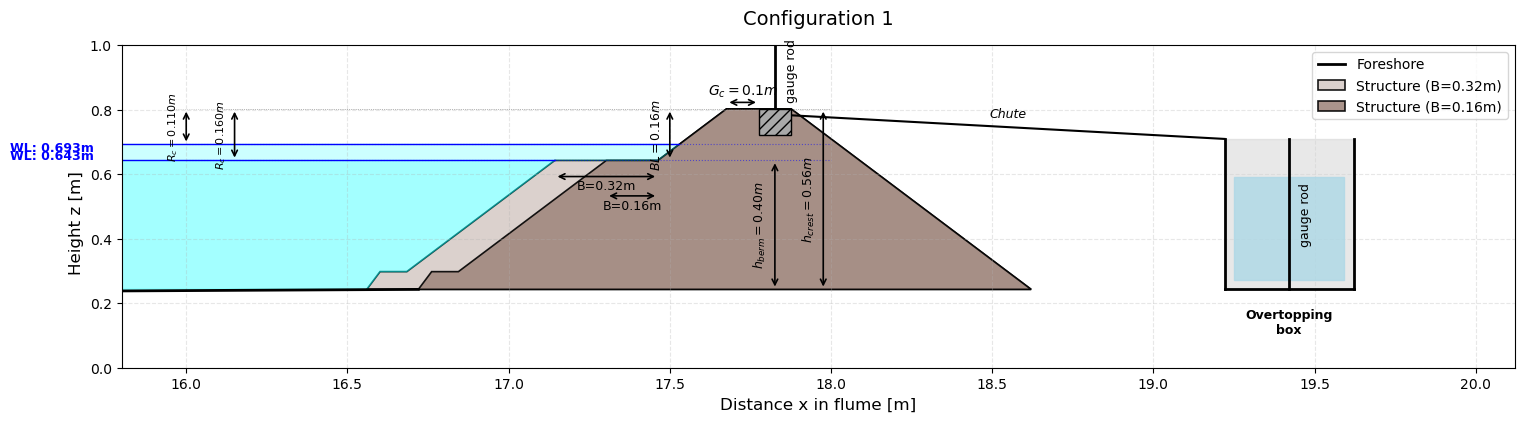

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np

# Vaste data (deze had je al)
x_fixed = np.array([0.0, 5.0, 5.91, 7.5, 10.0, 12.5, 15.0, 16.72])
z_fixed = np.array([0.0, 0.0, 0.0, 0.159, 0.209, 0.221, 0.234, 0.243])

def plot_breakwater_final_geometry(
    bh_rel, crest_h_rel, widths, hb_list, label_offsets,
    toe_w, toe_h, toe_sh, toe_sv, main_slope,
    x_bathy, z_bathy, toe_level,
    title,
    gc_width=0.10
):
    # Absolute hoogtes
    bh_abs = bh_rel + toe_level       
    crest_h_abs = crest_h_rel + toe_level 
    
    # Figuur aanmaken
    fig, ax = plt.subplots(figsize=(16, 8))
    
    fill_colors = ['#D7CCC8', '#A1887F']
    sorted_widths = sorted(widths, reverse=True) 
    min_width = sorted_widths[-1] 
    
    start_x_foreshore = x_bathy[-1] 
    start_z = z_bathy[-1]
    toe_slope_ratio = toe_sh / toe_sv
    
    # AFMETINGEN ELEMENTEN
    block_length = 0.10
    block_height = 0.08

    # --- 1. BEREKEN GEOMETRIE ---
    dx_toe_front = toe_h * toe_slope_ratio
    dx_to_berm = (bh_abs - (start_z + toe_h)) * main_slope
    dx_to_crest = (crest_h_abs - bh_abs) * main_slope
    
    # VAST ANKERPUNT (Kruin Start)
    x_crest_start_fixed = start_x_foreshore + dx_toe_front + toe_w + dx_to_berm + min_width + dx_to_crest
    x_crest_total_end = x_crest_start_fixed + gc_width + block_length
    
    # --- NIEUWE BEREKENING ACHTERTALUD ---
    # We berekenen hoever de helling naar rechts uitloopt tot aan de bodem (start_z)
    dx_rear_slope = (crest_h_abs - start_z) * main_slope  # <--- AANGEPAST: Extra breedte door helling
    x_rear_toe = x_crest_total_end + dx_rear_slope        # <--- AANGEPAST: X-coordinaat van de achterteen
    
    # BOX PARAMETERS (Verschoven op basis van achterteen)
    gap_to_box = 0.6  
    box_x_start = x_rear_toe + gap_to_box                 # <--- AANGEPAST: Box start nu na de achterteen
    box_width = 0.40 
    box_height = 0.7 / 1.5
    box_wall_thick = 0.03
    
    # --- A. BATHYMETRY ---
    plot_min_x = 15.5 
    mask = x_bathy >= 10.0 
    ax.plot(x_bathy[mask], z_bathy[mask], color='black', lw=2, label='Foreshore')
    ax.plot([plot_min_x, x_bathy[mask][0]], [z_bathy[mask][0], z_bathy[mask][0]], color='black', lw=2)
    
    widest_profile_coords = {} 

    # --- B. CONSTRUCTIE LOOP ---
    for i, B in enumerate(sorted_widths):
        x_poly = []
        z_poly = []
        
        # REKENEN VAN RECHTS NAAR LINKS
        x_berm_end = x_crest_start_fixed - dx_to_crest
        x_berm_start = x_berm_end - B
        x_toe_back = x_berm_start - dx_to_berm
        z_toe_top = start_z + toe_h
        x_toe_top_start = x_toe_back - toe_w
        x_structure_start = x_toe_top_start - dx_toe_front
        
        # POLYGOON BOUWEN
        x_poly.append(x_structure_start); z_poly.append(start_z)
        x_poly.append(x_toe_top_start);   z_poly.append(z_toe_top)
        x_poly.append(x_toe_back);        z_poly.append(z_toe_top)
        x_poly.append(x_berm_start);      z_poly.append(bh_abs)
        x_poly.append(x_berm_end);        z_poly.append(bh_abs)
        x_poly.append(x_crest_start_fixed); z_poly.append(crest_h_abs)
        x_poly.append(x_crest_total_end);   z_poly.append(crest_h_abs)
        
        # --- AANGEPAST: ACHTERTALUD TOEVOEGEN ---
        # In plaats van verticaal naar beneden, gaan we schuin naar de achterteen
        x_poly.append(x_rear_toe);        z_poly.append(start_z) 
        
        # Terug naar start
        x_poly.append(x_structure_start); z_poly.append(start_z)

        ax.fill(x_poly, z_poly, color=fill_colors[i % 2], 
                label=f'Structure (B={B}m)', alpha=0.9, edgecolor='black', linewidth=1.2)
        
        if i == 0:
            widest_profile_coords = {
                'start_x': x_structure_start, 'toe_top_start': x_toe_top_start,
                'toe_back': x_toe_back, 'berm_start': x_berm_start, 'berm_end': x_berm_end,
                'toe_z': z_toe_top
            }

        # PIJLEN: BERM BREEDTE
        z_arrow_depth = 0.05 + (i * 0.06) 
        z_arrow = bh_abs - z_arrow_depth
        ax.annotate('', xy=(x_berm_start, z_arrow), xytext=(x_berm_end, z_arrow),
                    arrowprops=dict(arrowstyle='<->', color='black', lw=1.2))
        ax.text((x_berm_start + x_berm_end)/2, z_arrow - 0.01, f'B={B}m', 
                ha='center', va='top', fontsize=9, color='black')

        # --- DETAIL TEKENINGEN ---
        if i == len(sorted_widths) - 1:
            # Betonblok
            x_block_start = x_crest_start_fixed + gc_width
            x_block_end = x_block_start + block_length
            rect_x = [x_block_start, x_block_end, x_block_end, x_block_start]
            rect_y = [crest_h_abs - block_height, crest_h_abs - block_height, crest_h_abs, crest_h_abs]
            ax.fill(rect_x, rect_y, color='darkgrey', hatch='///', edgecolor='black', zorder=10)

            # Gc Maatvoering
            dim_h_gc = crest_h_abs + 0.02 
            ax.annotate('', xy=(x_crest_start_fixed, dim_h_gc), xytext=(x_block_start, dim_h_gc),
                        arrowprops=dict(arrowstyle='<->', color='black', lw=1.2))
            ax.text((x_crest_start_fixed + x_block_start)/2, dim_h_gc + 0.01, 
                    f'$G_c={gc_width}m$', ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

            # Gauge Rod & Chute
            rod_x = x_block_start + (block_length / 2)
            ax.plot([rod_x, rod_x], [crest_h_abs, crest_h_abs + 0.25], color='black', lw=2)
            ax.text(rod_x + 0.03, crest_h_abs + 0.12, 'gauge rod', rotation=90, va='center', ha='left', fontsize=9, color='black')
            
            # Chute tekenen (verbindt blok met de nieuwe box positie)
            ax.plot([x_block_end, box_x_start], [crest_h_abs - 0.02, start_z + box_height], color='black', lw=1.5)
            mid_chute_x = (x_block_end + box_x_start) / 2
            mid_chute_z = (crest_h_abs - 0.02 + start_z + box_height) / 2
            ax.text(mid_chute_x, mid_chute_z + 0.02, 'Chute', ha='center', va='bottom', fontsize=9, fontstyle='italic')

    # --- Z. OVERTOPPING BOX ---
    ax.plot([box_x_start, box_x_start], [start_z + box_height, start_z], color='black', lw=2, zorder=5)
    ax.plot([box_x_start, box_x_start + box_width], [start_z, start_z], color='black', lw=2, zorder=5)
    ax.plot([box_x_start + box_width, box_x_start + box_width], [start_z, start_z + box_height], color='black', lw=2, zorder=5)
    
    box_x_poly = [box_x_start, box_x_start + box_width, box_x_start + box_width, box_x_start]
    box_y_poly = [start_z + box_height, start_z + box_height, start_z, start_z]
    ax.fill(box_x_poly, box_y_poly, color='lightgrey', alpha=0.5, zorder=4)

    # WATER & ROD IN BOX
    water_level_box = box_height * 0.75
    water_x = [box_x_start + box_wall_thick, box_x_start + box_width - box_wall_thick, 
               box_x_start + box_width - box_wall_thick, box_x_start + box_wall_thick]
    water_y = [start_z + water_level_box, start_z + water_level_box, start_z + box_wall_thick, start_z + box_wall_thick]
    ax.fill(water_x, water_y, color='lightblue', alpha=0.8, zorder=6)

    rod_box_x = box_x_start + box_width / 2
    ax.plot([rod_box_x, rod_box_x], [start_z, start_z + box_height], color='black', lw=2, zorder=7)
    ax.text(rod_box_x + 0.03, start_z + (box_height/2), 'gauge rod', 
            rotation=90, va='center', ha='left', fontsize=9, color='black', zorder=7)
    ax.text(box_x_start + box_width/2, start_z - 0.06, 'Overtopping\nbox', ha='center', va='top', fontsize=9, fontweight='bold')

    # --- C. WATER LEVELS ---
    x_view_min = plot_min_x
    wl_values = [] 
    
    w_start_x = widest_profile_coords['start_x']
    w_toe_top = widest_profile_coords['toe_top_start']
    w_toe_back = widest_profile_coords['toe_back']
    w_berm_start = widest_profile_coords['berm_start']
    w_berm_end = widest_profile_coords['berm_end']
    z_toe_top = widest_profile_coords['toe_z']

    for hb in hb_list:
        wl = bh_abs + hb
        wl_values.append(wl)
        
        # Polygoon logica voor water (blijft hetzelfde, dit is voor de voorkant)
        if wl <= z_toe_top:
            x_hit = w_start_x + (wl - start_z) * toe_slope_ratio
            poly_x = [x_view_min, w_start_x, x_hit, x_view_min]
            poly_y = [start_z, start_z, wl, wl]
        elif wl <= bh_abs:
            x_hit = w_toe_back + (wl - z_toe_top) * main_slope
            poly_x = [x_view_min, w_start_x, w_toe_top, w_toe_back, x_hit, x_view_min]
            poly_y = [start_z, start_z, z_toe_top, z_toe_top, wl, wl]
        else:
            x_hit = w_berm_end + (wl - bh_abs) * main_slope
            poly_x = [x_view_min, w_start_x, w_toe_top, w_toe_back, w_berm_start, w_berm_end, x_hit, x_view_min]
            poly_y = [start_z, start_z, z_toe_top, z_toe_top, bh_abs, bh_abs, wl, wl]

        ax.fill(poly_x, poly_y, color='cyan', alpha=0.2) 
        ax.plot([x_view_min, x_hit], [wl, wl], color='blue', lw=1.0) 

    # --- WATERLEVEL LABELS ---
    wl_values.sort(reverse=True)
    text_spacing = 0.025 
    start_y_txt = np.mean(wl_values) + ((len(wl_values) - 1) * text_spacing) / 2
    
    for i, wl in enumerate(wl_values):
        label_txt = f"WL: {wl:.3f}m"
        ax.text(-0.02, start_y_txt - (i * text_spacing), label_txt, 
                color='blue', va='center', ha='right', fontsize=9, fontweight='bold',
                transform=ax.get_yaxis_transform())


    # --- D. MAATVOERING ---
    x_dim_base = x_crest_start_fixed
    
    # H_crest
    x_dim_crest = x_dim_base + 0.30
    ax.annotate('', xy=(x_dim_crest, start_z), xytext=(x_dim_crest, crest_h_abs), arrowprops=dict(arrowstyle='<->', color='black', lw=1.2))
    ax.text(x_dim_crest - 0.02, (start_z + crest_h_abs)/2, f'$h_{{crest}}={crest_h_rel:.2f}m$', rotation=90, va='center', ha='right', fontsize=9)

    # H_berm
    x_dim_berm = x_dim_base + 0.15 
    ax.annotate('', xy=(x_dim_berm, start_z), xytext=(x_dim_berm, bh_abs), arrowprops=dict(arrowstyle='<->', color='black', lw=1.2))
    ax.text(x_dim_berm - 0.02, (start_z + bh_abs)/2, f'$h_{{berm}}={bh_rel:.2f}m$', rotation=90, va='center', ha='right', fontsize=9)


    # Rc (FREEBOARD)
    x_rc_fixed = 16.0
    sorted_hb_list = sorted(hb_list, reverse=True)
    rc_spacing = 0.15
    
    for i, hb in enumerate(sorted_hb_list):
        wl = bh_abs + hb
        rc_val = crest_h_abs - wl
        x_rc_curr = x_rc_fixed + (i * rc_spacing)
        
        ax.plot([x_rc_fixed, 18.0], [wl, wl], color='blue', linestyle=':', lw=0.8, alpha=0.5) 
        ax.annotate('', xy=(x_rc_curr, wl), xytext=(x_rc_curr, crest_h_abs), 
                    arrowprops=dict(arrowstyle='<->', color='black', lw=1.2))
        mid_z = (wl + crest_h_abs) / 2
        ax.text(x_rc_curr - 0.02, mid_z, f'$R_c={rc_val:.3f}m$', 
                rotation=90, va='center', ha='right', fontsize=8, color='black')
        ax.plot([x_rc_curr - 0.05, 18.0], [crest_h_abs, crest_h_abs], 'k:', lw=0.5, alpha=0.3)


    # BL (BERM LEVEL)
    x_bl_pos = 17.5
    bl_val = crest_h_rel - bh_rel
    ax.annotate('', xy=(x_bl_pos, bh_abs), xytext=(x_bl_pos, crest_h_abs), 
                arrowprops=dict(arrowstyle='<->', color='black', lw=1.2))
    ax.text(x_bl_pos - 0.02, (bh_abs + crest_h_abs)/2, f'$BL={bl_val:.2f}m$', 
            rotation=90, va='center', ha='right', fontsize=9, fontweight='bold', color='black')


    # --- E. STYLING ---
    ax.set_title(title, fontsize=14, pad=15)
    ax.set_xlabel("Distance x in flume [m]", fontsize=12)
    ax.set_ylabel("Height z [m]", fontsize=12, y=0.45)
    
    # CUTTING THE RIGHT HAND SIDE - Let op, misschien iets vergroten nu de box verder weg staat
    ax.set_xlim(15.8, box_x_start + box_width + 0.5) # Dynamische limiet zodat box altijd past
    ax.set_ylim(0, 1.0)
    
    ax.grid(True, which='both', alpha=0.3, linestyle='--')
    ax.set_aspect('equal')
    ax.legend(loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.subplots_adjust(left=0.12) 
    plt.show()

plot_breakwater_final_geometry(
    bh_rel=berm_heights[0], crest_h_rel=crest_height_hb1, 
    widths=berm_widths, 
    hb_list=h_b_list1, label_offsets=[0,0,0],
    toe_w=toe_w, toe_h=toe_h, 
    toe_sh=toe_sh, toe_sv=toe_sv, main_slope=cot_alpha,
    x_bathy=x_fixed, z_bathy=z_fixed, toe_level=toe_level, 
    title="Configuration 1",
    gc_width=0.10 
)

# --- AANROEP VOOR CONFIGURATIE 2 ---



# plot_breakwater_final_geometry(
#     bh_rel=berm_heights[1],        # Gebruik de tweede bermhoogte (indien verschillend)
#     crest_h_rel=crest_height_hb2,  # De kruinhoogte specifiek voor config 2
#     widths=berm_widths,            # De lijst met breedtes [0.2, 0.35]
#     hb_list=h_b_list2,             # De waterstanden relative aan berm voor config 2
#     label_offsets=[0, 0, 0],       # Eventuele offset voor labels (optioneel)
#     toe_w=toe_w,         # Teen breedte
#     toe_h=toe_h,        # Teen hoogte
#     toe_sh=toe_sh,            # Teen helling horizontaal
#     toe_sv=toe_sv,            # Teen helling verticaal
#     main_slope=cot_alpha,          # Taludhelling
#     x_bathy=x_fixed,               # Bodem profiel x
#     z_bathy=z_fixed,               # Bodem profiel z
#     toe_level=toe_level,           # Absolute hoogte van de teen
#     title="Configuration 2",       # Titel boven de grafiek
#     gc_width=0.10                  # Breedte tussen kruin en blok
# )

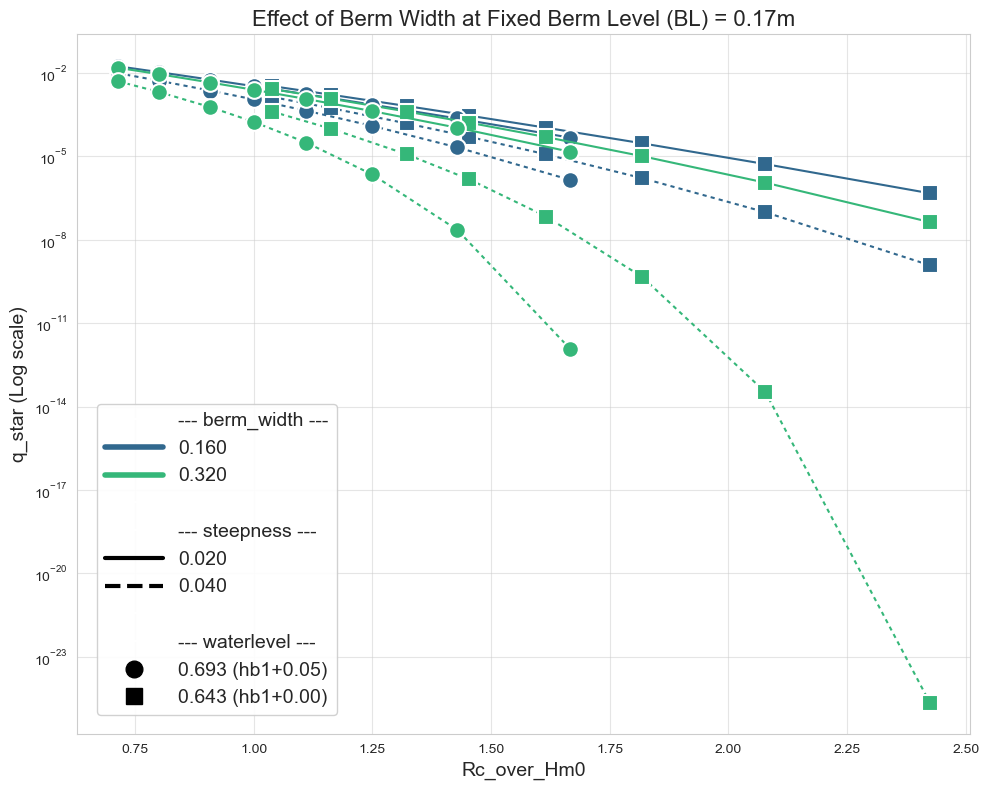

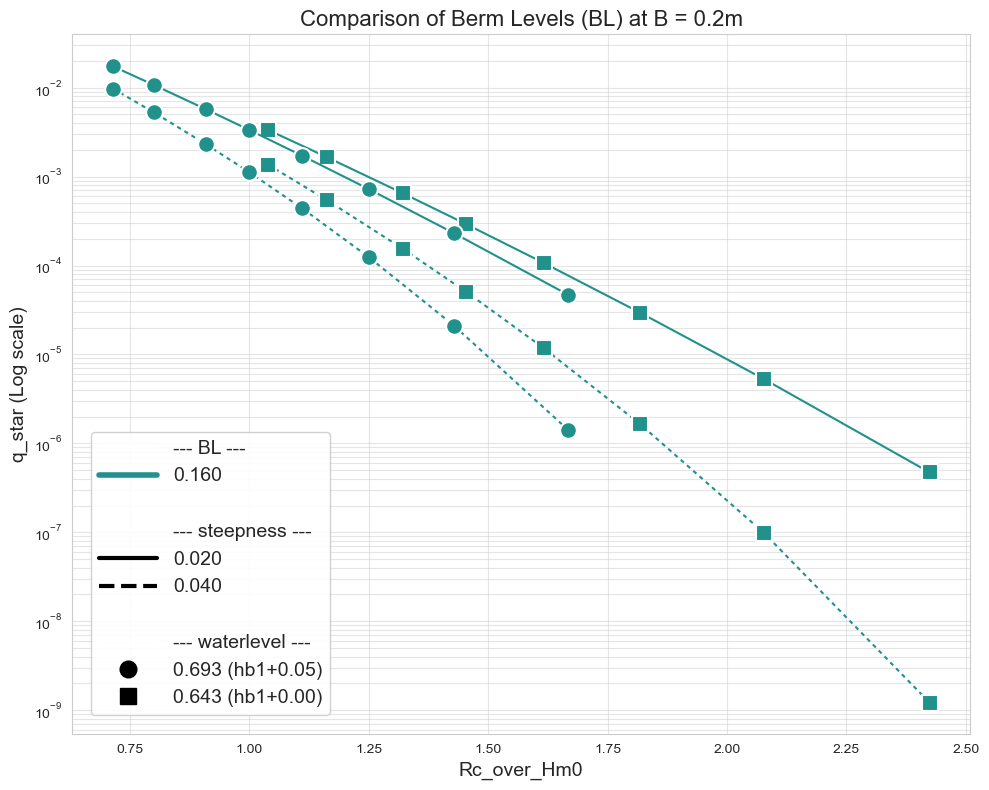

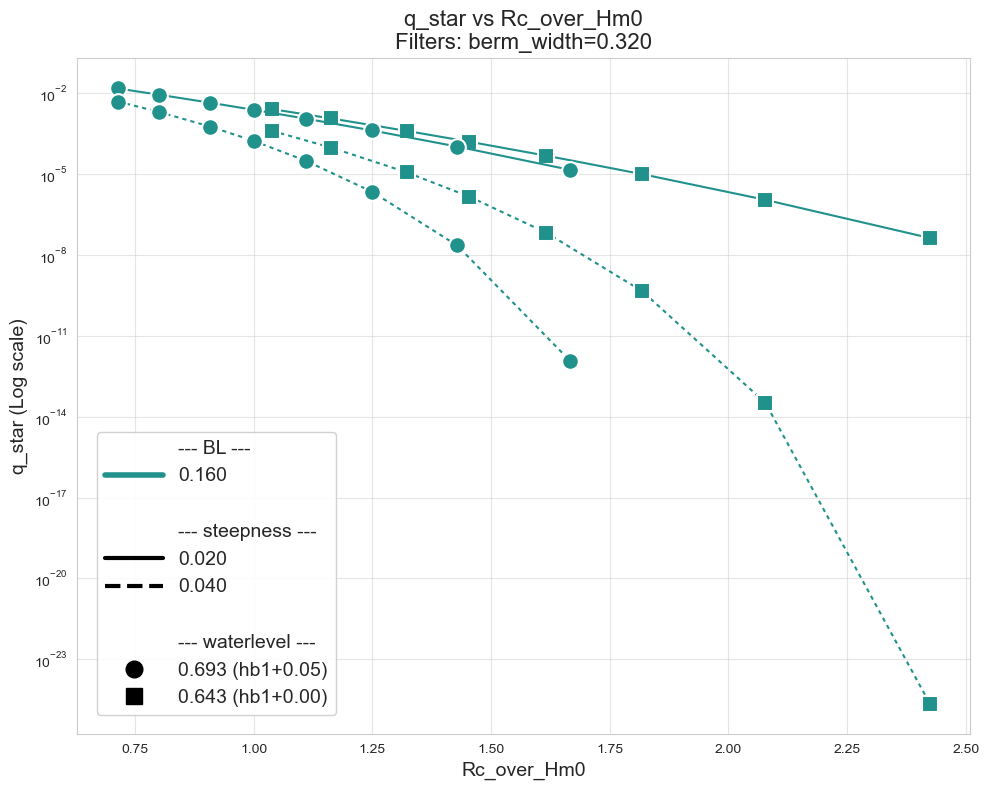

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

def plot_overtopping_data(df, x, y, hue=None, style=None, filters=None, title=None):
    """
    Plot function with Large Markers AND Large Legend (Text + Symbols)
    """
    
    # --- CONFIGURATIE ---
    mysize = 12         # Grootte van de markers in de plot én legenda
    legend_fontsize = 14 # Grootte van de tekst in de legenda (Standaard is ~10)
    
    # 1. Make a copy of the FULL dataset
    plot_data = df.copy()

    # --- STEP A: AUTO-GENERATE BERM CODES (AANGEPAST VOOR JOUW PROBLEEM) ---
    # We kijken nu naar de combinatie van berm_height EN crest_height.
    # Anders krijgen beide scenario's (die allebei bermhoogte 0.4 hebben) de naam 'hb1'.
    if 'berm_code' not in plot_data.columns:
        # Sorteer zodat de hoogste kruin hb1 wordt, en de lagere hb2
        unique_configs = plot_data[['berm_height', 'crest_height']].drop_duplicates().sort_values('crest_height', ascending=False)
        
        # Maak een dictionary: (berm_h, crest_h) -> "hb1", "hb2"
        config_map = {}
        for i, (idx, row) in enumerate(unique_configs.iterrows()):
            config_map[(row['berm_height'], row['crest_height'])] = f"hb{i+1}"
            
        # Pas toe op de data
        plot_data['berm_code'] = plot_data.apply(
            lambda r: config_map.get((r['berm_height'], r['crest_height']), "UNK"), axis=1
        )

    # --- STEP B: APPLY FILTERS ---
    filter_txt_list = []
    if filters:
        for col, value in filters.items():
            if col not in plot_data.columns: continue
            if isinstance(value, (int, float)):
                col_numeric = pd.to_numeric(plot_data[col], errors='coerce')
                plot_data = plot_data[np.isclose(col_numeric, value, atol=1e-5)]
                filter_txt_list.append(f"{col}={value:.3f}")
            else:
                plot_data = plot_data[plot_data[col] == value]
                filter_txt_list.append(f"{col}={value}")
    
    if plot_data.empty:
        print("WARNING: No data left after filtering!")
        return

    # Format Hue
    if isinstance(hue, str) and hue in plot_data.columns:
        if pd.api.types.is_numeric_dtype(plot_data[hue]):
            plot_data = plot_data.sort_values(by=hue)
            plot_data[hue] = plot_data[hue].apply(lambda x: f"{float(x):.3f}")

    # ---------------------------------------------------------
    # 2. LOGIC FOR LINE STYLES AND MARKERS
    # ---------------------------------------------------------
    if not isinstance(style, list) or len(style) != 2:
        print("ERROR: style must be a list, e.g.: ['steepness', 'waterlevel']")
        return

    col_line = style[0] 
    col_mark = style[1] 
    
    plot_data[col_line] = pd.to_numeric(plot_data[col_line])
    plot_data[col_mark] = pd.to_numeric(plot_data[col_mark])
    
    # UNIEKE ID MAKEN (AANGEPAST)
    # We voegen de 'berm_code' toe aan de ID. 
    # Hierdoor is "0.643 bij hb1" een andere ID dan "0.643 bij hb2".
    plot_data['marker_id'] = plot_data.apply(
        lambda r: f"{r[col_mark]:.3f}_{r['berm_code']}", axis=1
    )

    vals_line = np.sort(plot_data[col_line].unique())         
    
    unique_marker_ids = plot_data[['marker_id', col_mark, 'berm_code']].drop_duplicates()
    # Sorteren zorgt dat hb1 en hb2 netjes gegroepeerd staan in de legenda
    unique_marker_ids = unique_marker_ids.sort_values(
        by=['berm_code', col_mark], ascending=[True, False]
    )
    vals_marker_id = unique_marker_ids['marker_id'].values

    dash_styles = ["", (2, 2)] 
    mpl_lines = ['-', '--']
    # Iets meer markers toegevoegd voor de zekerheid, voor als je veel waterlevels hebt
    marker_styles = ['o', 's', '^', 'D', 'v', 'X', 'P', '*', 'h', '+', 'p', '<', '>']
    
    line_map_sns = {val: dash_styles[i % 2] for i, val in enumerate(vals_line)}
    line_map_mpl = {val: mpl_lines[i % 2] for i, val in enumerate(vals_line)}
    mark_map = {mid: marker_styles[i % len(marker_styles)] for i, mid in enumerate(vals_marker_id)}
    
    plot_data['combo_style'] = plot_data.apply(lambda row: f"{row[col_line]}_{row['marker_id']}", axis=1)
    
    plot_dashes = {}
    plot_markers = {}
    for v_l in vals_line:
        for mid in vals_marker_id:
            key = f"{v_l}_{mid}"
            plot_dashes[key] = line_map_sns[v_l]
            plot_markers[key] = mark_map[mid]

    # ---------------------------------------------------------
    # 3. THE PLOT
    # ---------------------------------------------------------
    plt.figure(figsize=(10, 8))
    sns.set_style("whitegrid")
    
    unique_hues = np.sort(plot_data[hue].unique())
    palette = sns.color_palette("viridis", n_colors=len(unique_hues))
    color_map = dict(zip(unique_hues, palette))
    
    ax = sns.lineplot(
        data=plot_data, x=x, y=y, hue=hue, style='combo_style',
        markers=plot_markers, dashes=plot_dashes, palette=palette,
        errorbar=None, legend=False,
        markersize=mysize, markeredgewidth=1.5 
    )
    
    # ---------------------------------------------------------
    # 4. MANUAL LEGEND (LARGE)
    # ---------------------------------------------------------
    legend_handles = []
    
    # HUE
    legend_handles.append(mlines.Line2D([], [], color='white', label=f"--- {hue} ---", markersize=0)) # spacer
    for h_val in unique_hues:
        # lw=3 maakt de lijn in de legenda ook wat dikker/duidelijker
        legend_handles.append(mlines.Line2D([], [], color=color_map[h_val], label=h_val, lw=4))

    # STEEPNESS
    legend_handles.append(mlines.Line2D([], [], color='white', label=" ", markersize=0))
    legend_handles.append(mlines.Line2D([], [], color='white', label=f"--- {col_line} ---", markersize=0))
    for l_val in vals_line:
        ls = line_map_mpl[l_val]
        legend_handles.append(mlines.Line2D([], [], color='black', linestyle=ls, label=f"{l_val:.3f}", lw=3))

    # WATERLEVEL (MARKERS)
    legend_handles.append(mlines.Line2D([], [], color='white', label=" ", markersize=0))
    legend_handles.append(mlines.Line2D([], [], color='white', label=f"--- {col_mark} ---", markersize=0))
    
    for mid in vals_marker_id:
        ms = mark_map[mid]
        subset = plot_data[plot_data['marker_id'] == mid].iloc[0]
        water_val = subset[col_mark]
        hb_val = subset['h_b']
        b_code = subset['berm_code'] 
        
        sign = "+" if hb_val >= 0 else ""
        # Hier staat nu de correcte code (hb1 of hb2) in de tekst
        label_text = f"{water_val:.3f} ({b_code}{sign}{hb_val:.2f})"
        
        # markersize=mysize zorgt dat ze ook in de legenda groot zijn
        legend_handles.append(mlines.Line2D([], [], color='black', marker=ms, linestyle='None', 
                                            label=label_text, markersize=mysize))

    # --- AANPASSINGEN VOOR GROTE LEGENDA ---
    # fontsize: grootte van de tekst
    # handlelength: lengte van de lijnstukjes (zodat ze niet te kort lijken bij grote tekst)
    ax.legend(
        handles=legend_handles, 
        loc='lower left', 
        frameon=True, 
        framealpha=0.9, 
        borderaxespad=1,
        fontsize=legend_fontsize,  # <--- GROTERE TEKST
        handlelength=3             # <--- BREDERE SYMBOLEN/LIJNEN
    )

    if 'q' in y.lower():
        plt.yscale('log')
        plt.ylabel(f"{y} (Log scale)", fontsize=14) # As-labels ook iets groter
    else:
        plt.ylabel(y, fontsize=14)
    
    plt.xlabel(x, fontsize=14)
    
    # Titel ook wat groter
    if title: plt.title(title, fontsize=16)
    else: plt.title(f"{y} vs {x}\nFilters: {', '.join(filter_txt_list)}", fontsize=16)
        
    plt.grid(True, which="both", alpha=0.5)
    plt.tight_layout()
    plt.show()

# 1. Effect of water level on absolute overtopping (q)
plot_overtopping_data(
    df=df_results_complete,
    x="Rc_over_Hm0",
    y="q_star",
    hue="berm_width",
    style=["steepness", "waterlevel"],
    filters={'BL': 0.12}, 
    title=f"Berm Effectiveness at Berm Level (BL) = 0.13m"
)

# 2. Dimensionless overtopping (q_star) for one specific berm configuration (BL)
plot_overtopping_data(
    df=df_results_complete,
    x="Rc_over_Hm0",
    y="q_star",
    hue="berm_width",
    style=["steepness", "waterlevel"],
    filters={'BL': 0.16},  # Adjust this value to a BL present in your data
    title="Effect of Berm Width at Fixed Berm Level (BL) = 0.17m"
)

# 3. Comparison between different Berm Heights (BL)
plot_overtopping_data(
    df=df_results_complete,
    x="Rc_over_Hm0",
    y="q_star",
    hue="BL",  # Color now represents the berm height configuration
    style=["steepness", "waterlevel"],
    filters={'berm_width': 0.16}, 
    title="Comparison of Berm Levels (BL) at B = 0.2m"
)

# 4. Effectiveness of Berm Width at a specific water level offset
plot_overtopping_data(
    df=df_results_complete,
    x="Rc_over_Hm0",
    y="q_star",
    hue="BL",
    style=["steepness", "waterlevel"],
    filters={'berm_width': 0.32}, # Specific check for wide berms
)

In [7]:
#Wave flume plot inclusief breakwater

import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

def plot_breakwater_with_toe(
    crest_height,
    berm_level,
    waterlevels,
    berm_width,
    crest_width,
    # Inputs voor de Toe (Teen)
    toe_width,
    toe_height, 
    toe_slope_H=2, 
    toe_slope_V=3,
    # Inputs voor Main Structure
    slope_H=3,
    slope_V=4
):
    # --- 1. VASTE BATHYMETRIE ---
    x_fixed = np.array([0.0, 5.0, 5.91, 7.5, 10.0, 12.5, 15.0, 16.72])
    z_fixed = np.array([0.0, 0.0, 0.0, 0.159, 0.209, 0.221, 0.234, 0.243])
    
    start_x = x_fixed[-1]
    start_z = z_fixed[-1] 

    # --- 2. CONSTRUCTIE GEOMETRIE ---
    main_slope_ratio = slope_H / slope_V
    toe_slope_ratio = toe_slope_H / toe_slope_V

    # A. De Teen
    z_toe_top = start_z + toe_height
    dx_toe_front = toe_height * toe_slope_ratio
    x_toe_top_start = start_x + dx_toe_front
    
    x_toe_back = x_toe_top_start + toe_width
    z_toe_back = z_toe_top

    # B. Hoofdtalud naar Berm
    dz_to_berm = berm_level - z_toe_back
    dx_to_berm = dz_to_berm * main_slope_ratio
    x_berm_start = x_toe_back + dx_to_berm
    
    # C. Horizontale Berm
    x_berm_end = x_berm_start + berm_width
    
    # D. Helling naar Crest
    dz_to_crest = crest_height - berm_level
    dx_to_crest = dz_to_crest * main_slope_ratio
    x_crest_start = x_berm_end + dx_to_crest
    
    # E. Horizontale Crest
    x_crest_end = x_crest_start + crest_width
    
    # F. Achterkant
    dz_down = crest_height - start_z
    dx_down = dz_down * main_slope_ratio
    x_end = x_crest_end + dx_down

    # Samenstellen
    x_bw = np.array([start_x, x_toe_top_start, x_toe_back, x_berm_start, x_berm_end, x_crest_start, x_crest_end, x_end])
    z_bw = np.array([start_z, z_toe_top,       z_toe_back, berm_level,  berm_level, crest_height, crest_height, start_z])

    # --- 3. PLOTTEN ---
    fig, ax = plt.subplots(figsize=(12, 6))

    # AANPASSING 1: Water doortrekken tot 25m
    wl_max = np.max(waterlevels)
    ax.fill_between([0, 25.0], 0, wl_max, color="#d4ebf2", alpha=1.0, zorder=0)

    # Bathymetrie (vooroever)
    ax.plot(x_fixed, z_fixed, color="black", linewidth=2.5, zorder=2)

    # Breakwater
    ax.fill(x_bw, z_bw, color="lightgrey", edgecolor="black", linewidth=2.5, zorder=3)
    # Hulplijn teen
    ax.plot([x_toe_back, x_toe_back], [start_z, z_toe_back], 'k--', linewidth=0.5, alpha=0.5)

    # AANPASSING 2: Golfbak doortrekken
    # We tekenen een lijn vanaf het einde van de constructie (x_end) tot 25m
    # op de hoogte waarop de constructie begon/eindigde (start_z).
    ax.plot([x_end, 25.0], [start_z, start_z], color="black", linewidth=2.5, zorder=2)

    # Waterniveaus
    for wl in waterlevels:
        ax.axhline(wl, linestyle="--", linewidth=1.5, color="royalblue", zorder=1)
        
        ax.text(
            -0.04, wl, 
            f"SWL = {wl:.3f} m", 
            color="blue", fontsize=8, fontweight='bold', zorder=4,
            transform=ax.get_yaxis_transform(), 
            ha="right", 
            va="center"
        )

    # Labels

    # Assen
    ax.set_xlabel("X-distance in flume (m)")
    ax.set_ylabel("Height in flume (m)")
    
    # AANPASSING 3: Limiet van de as op 25 zetten
    ax.set_xlim(0, 25)
    
    ax.set_ylim(0, max(crest_height, wl_max) + 0.2)
    ax.grid(True, color='#cccccc', linestyle='-', alpha=0.5, zorder=0)
    ax.set_title("Flume set-up")
    
    plt.tight_layout()
    plt.show()

# Inputs (deze worden overgenomen uit je eerdere context)
# Zorg dat deze variabelen gedefinieerd zijn voordat je de functie aanroept
# (Hieronder staan ze ingevuld voor de zekerheid)


# Geometrie schattingen op basis van Dn50
berm_width = 0.35 
crest_width = 3 * Dn50
toe_width = 3 * Dn50
toe_height = 2 * Dn50

plot_breakwater_with_toe(
    crest_height=crest_height,
    berm_level=berm_level,
    waterlevels=[0.5],
    berm_width=berm_width,
    crest_width=crest_width,
    toe_width=toe_width,
    toe_height=toe_height,
    slope_H=cot_alpha,
    slope_V=1.0
)


NameError: name 'crest_height' is not defined